# Homework 4 (100 Points)

## Exercise 1 (40pts)

In this exercise we will implement a Natural Language Processing (NLP) system using binary logistic regression.

The data you will be working with comes from the [Yelp Dataset](https://www.yelp.com/dataset). Each line is a review that consists of a label (0 for negative reviews and 1 for positive reviews) and a set of words.

```
1 i will never forget this single breakfast experience in mad...
0 the search for decent chinese takeout in madison continues ...
0 sorry but me julio fell way below the standard even for med...
1 so this is the kind of food that will kill you so there s t...
```

In order to transform the set of words into vectors, we will rely on a method of feature engineering called word embeddings. Rather than simply indicating which words are present, word embeddings represent each word by "embedding" it in a low-dimensional vector space which may carry more information about the semantic meaning of the word. (for example in this space, the words "King" and "Queen" would be close).

`word2vec.txt` contains the `word2vec` embeddings for about 15 thousand words. Not every word in each review is present in the provided `word2vec.txt` file. We can treat these words as being "out of vocabulary" and ignore them.

### Example

Let x_i denote the sentence `“a hot dog is not a sandwich because it is not square”` and let a toy word2vec dictionary be as follows:

```
hot      0.1     0.2     0.3
not      -0.1    0.2     -0.3
sandwich 0.0     -0.2    0.4
square   0.2     -0.1    0.5
```

we would first `trim` the sentence to only contain words in our vocabulary: `"hot not sandwich not square”` then embed x_i into the feature space:

$$ φ2(x_i)) = \frac{1}{5} (word2vec(\text{hot}) + 2 · word2vec(\text{not}) + word2vec(\text{sandwich}) + word2vec(\text{square})) = \left[0.02 \hspace{2mm} 0.06 \hspace{2mm} 0.12 \hspace{2mm}\right]^T $$

### Part 1 (20pts)

a) Implement a function to trim out-of-vocabulary words from the reviews. Your function should return an nd array of the same dimension and dtype as the original loaded dataset. (10pts)

In [1]:
import csv
import numpy as np

VECTOR_LEN = 300   # Length of word2vec vector
MAX_WORD_LEN = 64  # Max word length in dict.txt and word2vec.txt

################################################################################
# We have provided you the functions for loading the tsv and txt files. Feel   #
# free to use them! No need to change them at all.                             #
################################################################################


def load_tsv_dataset(file):
    """
    Loads raw data and returns a tuple containing the reviews and their ratings.

    Parameters:
        file (str): File path to the dataset tsv file.

    Returns:
        An np.ndarray of shape N. N is the number of data points in the tsv file.
        Each element dataset[i] is a tuple (label, review), where the label is
        an integer (0 or 1) and the review is a string.
    """
    dataset = np.loadtxt(file, delimiter='\t', comments=None, encoding='utf-8',
                         dtype='l,O')
    return dataset


def load_feature_dictionary(file):
    """
    Creates a map of words to vectors using the file that has the word2vec
    embeddings.

    Parameters:
        file (str): File path to the word2vec embedding file.

    Returns:
        A dictionary indexed by words, returning the corresponding word2vec
        embedding np.ndarray.
    """
    word2vec_map = dict()
    with open(file) as f:
        read_file = csv.reader(f, delimiter='\t')
        for row in read_file:
            word, embedding = row[0], row[1:]
            word2vec_map[word] = np.array(embedding, dtype=float)
    return word2vec_map

word2Vec = load_feature_dictionary("./data/word2vec.txt")
def trim_reviews(path_to_dataset):
    # Load the dataset
    dataset = load_tsv_dataset(path_to_dataset)
    
    for i, (label, review) in enumerate(dataset):
        words = review.split()
        trimmed_words = []
        for word in words:
            if word in word2Vec:
                trimmed_words.append(word)
        dataset[i] = (label, trimmed_words)

    return dataset


trim_train = trim_reviews("./data/train_small.tsv")
trim_test = trim_reviews("./data/test_small.tsv")
#print(trim_train)

b) Implement the embedding and store it to a `.tsv` file where the first column is the label and the rest are the features from the embedding. Round all numbers to 6 decimal places. `embedded_train_small.tsv` and `embedded_test_small.tsv` contain the expected output of your function. (10pts)

In [2]:
def embed_reviews(trimmed_dataset):
    embedded_dataset = []
    for label, review in trimmed_dataset:
        embedded_review = 0.0
        for word in review:
            embedded_review += word2Vec[word]

        embedded_review = embedded_review/len(review)

        embedded_dataset.append((label,embedded_review))
    return embedded_dataset


def save_as_tsv(dataset, filename):
    with open(filename, 'w+') as f:
        #print(dataset)
        for label, review in dataset:
            embedding_str = [format(x,".6f") for x in review]
            row = [format(label,".6f")] + embedding_str
            f.writelines('\t'.join(row) + '\n')
    f.close()


embedded_train = embed_reviews(trim_train)
embedded_test = embed_reviews(trim_test)

#print(embedded_train)

save_as_tsv(embedded_train, "./data/output/embedded_train_small.tsv")
save_as_tsv(embedded_test, "./data/output/embedded_test_small.tsv")

### Part 2 (20pts)

In this part we'll be implementing Gradient Descent for binary Logistic Regression Classifier.

Some rules:

1. Include an intercept term in your model. You must consider the bias term as part of the weight vector and not a separate term to keep track of.
2. Initialize all model parameters to 0
3. Use vector and matrix multiplication

The expected `metrics.txt` from the dataset with `500` epochs and `0.001` learning rate is:

```
error(train): 0.000000
error(test): 0.625000
```

We will be testing your code on other, larger datasets.

In [3]:
import numpy as np

def load_tsv_dataset(file):
    return np.loadtxt(file, delimiter='\t', encoding='utf-8')


def sigmoid(x):
    e = np.exp(x)
    return e / (1 + e)


def gd(theta, X, y, learning_rate):
    # TODO: implement in vector form
    m = X.shape[0]
    h = sigmoid(X.dot(theta))
    gradient = (1 / m) * X.T.dot(h - y)
    theta = theta - learning_rate * gradient
    return theta


def train(theta, X, y, num_epoch, learning_rate):
    m = len(y)
    for epoch in range(num_epoch):
        theta = gd(theta, X, y, learning_rate)
    return theta


def predict(theta, X):
    # TODO: implement in vector form
    return np.round(sigmoid(X.dot(theta)))


def compute_error(y_pred, y):
    # TODO: implement in vector form
    return np.mean(y_pred != y)


def write_metrics(train_err, test_err, metrics_out):
    with open(metrics_out, 'w+') as f:
        w = "error(train): " + "{:.6f}".format(train_err) + "\n"
        w += "error(test): " + "{:.6f}".format(test_err) + "\n"
        f.write(w)
    return


def logistic_reg(formatted_train, formatted_test, metrics_out, num_epochs, learning_rate):
    
    train_data = load_tsv_dataset(formatted_train)
    test_data = load_tsv_dataset(formatted_test)
    
    
    y = train_data[:, 0]
    X = train_data[:, 1:]
    
    
    X= np.hstack((np.ones((len(y), 1)), X))
    theta = np.zeros(X.shape[1])

    learned_theta = train(theta, X, y, num_epochs, learning_rate)
    train_pred = predict(learned_theta, X)
    train_err = compute_error(train_pred, y)

    X_test = test_data[:, 1:]
    y_test = test_data[:, 0]
    
    X_test = np.hstack((np.ones((len(y_test), 1)), X_test))
    test_pred = predict(learned_theta, X_test)
    test_err = compute_error(test_pred, y_test)

    write_metrics(train_err, test_err, metrics_out)
    print(train_err,test_err)
    return


logistic_reg("./data/output/embedded_train_small.tsv", "./data/output/embedded_test_small.tsv", "metrics.txt", 500, 0.01)

0.0 0.625


## Exercise 2 (60 Points)

For this exercise, recall the lab's kaggle competition where you predicted if a cookie was defective or not (assuming you attend labs). For more information on the data and details, [click here to view the competition and data details](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/data)

However, what we will do differently here is check if two of the features were correlated. This is important because if two features are correlated, then we can remove one of the features and still get the same information. This is part of the feature selection process.

### Loading in the Data

For this exercise, we are interested in the two features `Texture Hardness` and `Texture Chewiness` and want to see if they are related. To do this, we will load in the data and create a scatter plot of the two features.

**a)** (1 Point) Download the kaggle data from the link above and read in the `csv` files `cookie_train.csv` and `cookie_test.csv`

In [15]:
import pandas as pd
#Code in this cell
test_data = pd.read_csv('./data/cookie_test.csv')
train_data = pd.read_csv('./data/cookie_train.csv')

### Combining Training and Testing Data

The lab did not have a lot of cookies for the training set, so what we will do is combine the training and testing data together without any loss of generality.

**b)** (3 Point) Combine the training and testing data together into a single dataframe called `cookie_data` and plot the scatter plot for `Texture Chewiness` (our y or our response variable) and `Texture Hardness` (our x or our explanatory variable). Make sure to label your axes and give your plot a title.

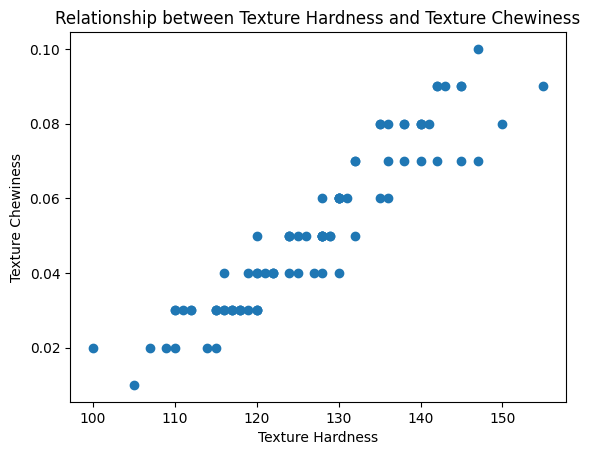

In [23]:
import matplotlib.pyplot as plt

cookie_data = pd.concat([train_data, test_data], ignore_index=True)

plt.scatter(cookie_data['Texture Hardness'], cookie_data['Texture Chewiness'])
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Relationship between Texture Hardness and Texture Chewiness')
plt.show()

### Checking If We Can Do Linear Regression

It is important to check all requirements/assumptions for linear regression are met before we do linear regression. One of the requirements is that the explanatory variable and response variable are linearly related, which we checked by noticing the scatter plot was linear. However, there is much more to check!

#### Checking for Normality
It is important to check that the response variable is normally distributed. This is important for hypothesis testing and relates to the idea of linear regression being an unbiased, minimum variance estimator (if you're interested in this, check out the course CAS MA 582).


**c) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the normality assumption. State whether the normality assumption is met or not. If it is not met, state what can we do to fix this.

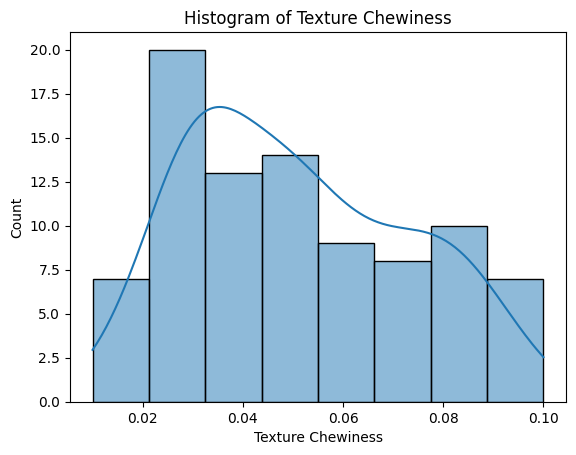

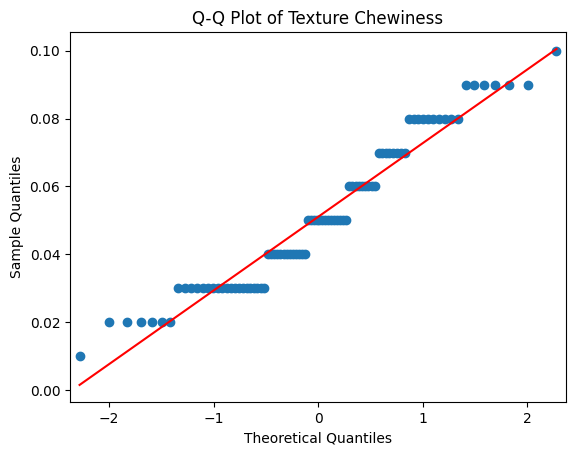

In [24]:
#Plot in this cell
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

sns.histplot(data=cookie_data, x='Texture Chewiness', kde=True)
plt.title('Histogram of Texture Chewiness')
plt.show()

sm.qqplot(cookie_data['Texture Chewiness'], line='s')
plt.title('Q-Q Plot of Texture Chewiness')

plt.show()

In the Q-Q plot and the histogram, we can see the data is a little skewed. In the current plots, we y is dependent on x. To see the distribution without this dependence, we use the residual graph.

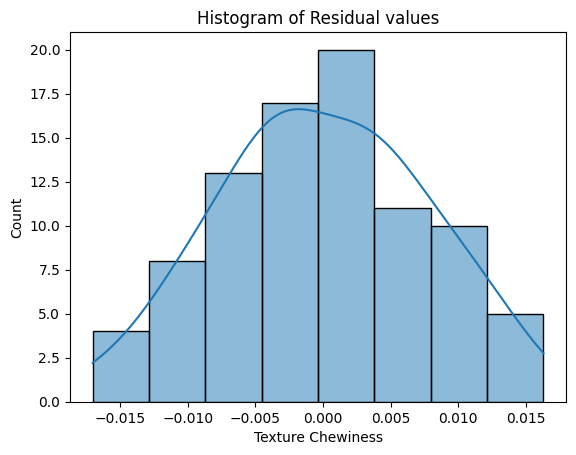

In [25]:
from statsmodels.stats.stattools import durbin_watson

#Code in this cell
from sklearn.linear_model import LinearRegression
X = cookie_data[['Texture Hardness']]
y = cookie_data['Texture Chewiness']

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)
residuals = y - y_pred

sns.histplot(data=residuals, kde=True)
plt.title('Histogram of Residual values')
plt.show()


As the histogram is approximately bell-shaped, we can conclude that the normality assumption is met.

#### Checking for Homoscedasticity
It is important to check that the variance of the response variable is the same across all values of the explanatory variable. Otherwise, the confidence around a predicted value of the response variable will vary depending on the explanatory variable value.

**d) (5 Points)** Plot an appropriate graph to determine if the response variable `Texture Chewiness` follows the homoscedasticity assumption. State whether the homoscedasticity assumption is met or not. If it is not met, state what can we do to fix this.

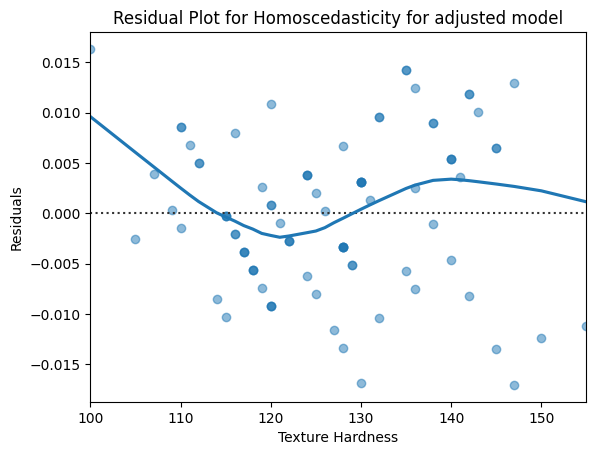

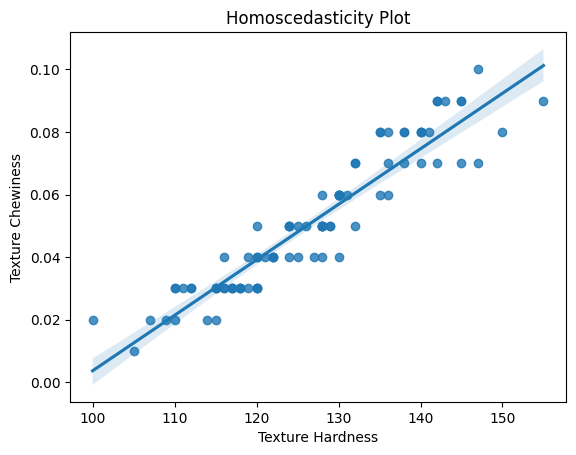

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.residplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data, lowess=True, scatter_kws={'alpha': 0.5})
plt.xlabel('Texture Hardness')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity for adjusted model')
plt.show()

sns.regplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Homoscedasticity Plot')
plt.show()

We can see a diagonal pattern in the residual values <br />
Since the variance of the residuals is constant across all predicted values, i.e. 
the plot shows a roughly constant spread of residuals across all levels of Texture Hardness, indicating that the homoscedasticity assumption is met.

#### Checking for Independence
It is important to check that the explanatory variable and response variable are independent. Otherwise, the model isn't really best fit with a line. To do so, we will use the Durbin-Watson test.

**e) (5 Points)** Use the Durbin-Watson test to determine if the explanatory variable and response variable are independent. State whether if the independence assumption is met or not. If it is not met, state what can we do to fix this. You may use any library to do this, and for more information, check out [this link](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).

In [27]:
dw_statistic = durbin_watson(residuals)

print("Durbin-Watson statistic:", dw_statistic)

Durbin-Watson statistic: 2.2797136857816565


The Durbin-Watson statistic tests for the presence of autocorrelation in the residuals of a regression model. A value of 2 indicates no autocorrelation, while values less than 2 indicate positive autocorrelation and values greater than 2 indicate negative autocorrelation. <br />
For our model, since the value is a little greater than 2, there is negative auto-correlation in the residuals and the independence assumption is not met. <br />
To fix this, we try transforming the data, such as taking the logarithm or square root, which may help reduce the effect of autocorrelation.

#### Adjusting the Model
If you think any of the assumptions are not met, then you should respectively fix the model.

**f) (6 Points)** If you think atleast one of the assumptions were not met, then adjust the model how you described you would. Otherwise, proceed to the next step and in the cell below, write "No adjustments were made to the model". However, if you do adjust the model, then in the cell below, justify why your adjustments is appropriate (i.e. plot the new graphs and statistics found above). You may add as many cells as you like.

In [28]:
#Code in this cell
import pandas as pd
import statsmodels.api as sm
import numpy as np

data=cookie_data
data["Texture Chewiness"] = np.log(data["Texture Chewiness"])
data['Texture Hardness']=np.log(data['Texture Hardness'])
X = data[['Texture Hardness']]
y = data['Texture Chewiness']

X = sm.add_constant(X)

model_adj = sm.OLS(y, X).fit()

print(model_adj.summary())


                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.03e-39
Time:                        19:16:13   Log-Likelihood:                 32.212
No. Observations:                  88   AIC:                            -60.42
Df Residuals:                      86   BIC:                            -55.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -26.1418      0.966  

Because the Durbin-Watson score was 2.2, several methods were tried in order to reduce correlation, like taking the square root, logarithm, and reciprocal of the 'Texture Chewiness' column and 'Texture Hardness' column. Taking the log of Texture Chewiness and Texture Hardness column helped in decreasing the Durbin-Watson score the most, from 2.279 to 2.112 and gives an R-squared error of 0.869

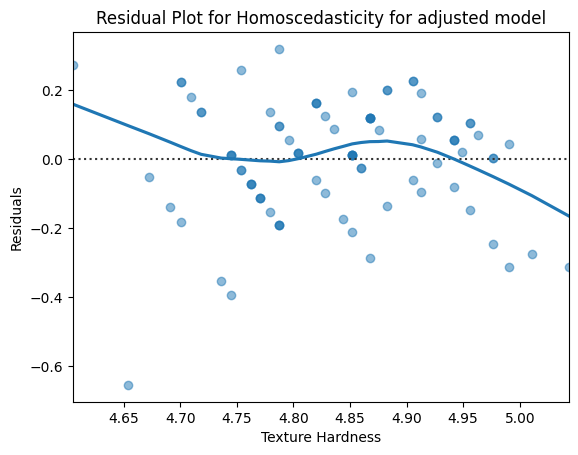

In [30]:
sns.residplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data, lowess=True, scatter_kws={'alpha': 0.5})
plt.xlabel('Texture Hardness')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity for adjusted model')
plt.show()


From the above plots we can see that the residual points are more aligned in a diagonal fashion with the Texture Hardness

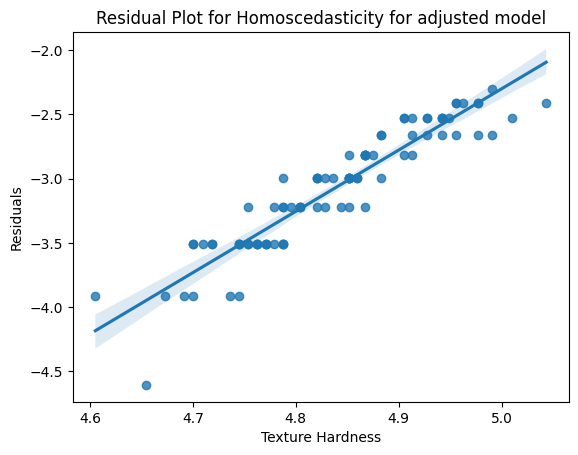

In [31]:
sns.regplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data)
plt.xlabel('Texture Hardness')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity for adjusted model')
plt.show()

### Hypothesis Testing
Now that we have a model that is appropriate, we can do hypothesis testing. We will be using the Linear Regression t-test to test if the explanatory variable is a significant predictor of the response variable.

**g) (5 Points)** Use the Linear Regression t-test to determine if the explanatory variable `Texture Hardness` is a significant predictor of the response variable `Texture Chewiness`. State whether if the explanatory variable is a significant predictor of the response variable or not using an alpha significance level of $\alpha = 0.05$, the null hypothesis $\beta_{hardness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

In [32]:
t_test = model_adj.t_test("Texture Hardness = 0")

# Extract p-value
p_value = t_test.pvalue.item()

alpha = 0.05
if p_value < alpha:
    print("significant predictor "+ str(p_value))
else:
    print("not significant predictor " + str(p_value))

significant predictor 1.0264720978763486e-39


Since the p_value is below the threshold alpha, the explanatory variable is a significant predictor of the response variable.

### Adding a New Feature
Now that we have determined that the explanatory variable is a significant predictor of the response variable, you noticed the fit isn't 100% perfect still (e.g. your model is not capturing all the variation in the data). You think that there is another feature that can help improve the model. You think that the feature `Taste Sweetness` can help improve your model. You want to test if this is true. You may assume that all the assumptions are met for this new model to conduct linear regression.

**h) (10 Points)** Now that you have two features to predict your response variable, you will have to use multiple linear regression. Use the `statsmodels` library to do multiple linear regression. Then, determine if the explanatory variables `Texture Hardness` and `Taste Sweetness` are significant predictors of the response variable `Texture Chewiness` using an alpha significance level of $\alpha = 0.001$, the null hypothesis $\beta_{hardness} = 0$ and $\beta_{sweetness} = 0$ and alternative hypothesis $\beta_{hardness} \neq 0$ and $\beta_{sweetness} \neq 0$. If it is not, state what can we do to fix this. You may use any library to do this.

Moreover, justify whether the overall model is significant or not using the F-test with the same $\alpha$ given above. If it is not, state what can we do to fix this.

_You may use the transformed model made (if one was made) from the previous parts and add this new feature to it._

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     355.6
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           5.11e-42
Time:                        19:20:11   Log-Likelihood:                 41.226
No. Observations:                  88   AIC:                            -76.45
Df Residuals:                      85   BIC:                            -69.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -20.1494      1.621  

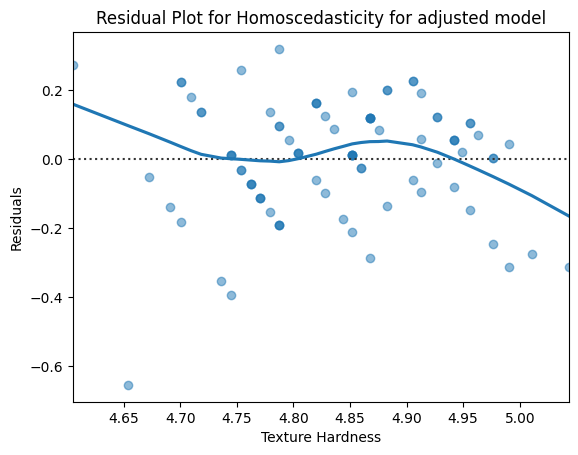

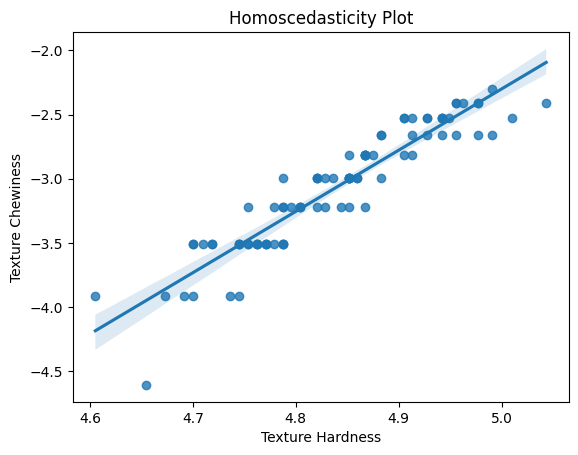

In [33]:
#Your code in this cell
import pandas as pd
import statsmodels.api as sm

X = data[['Texture Hardness', 'Taste Sweetness']]
y = data['Texture Chewiness']

# add constant column to X
X = sm.add_constant(X)

# fit model
model = sm.OLS(y, X).fit()

# print summary
print(model.summary())

sns.residplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data, lowess=True, scatter_kws={'alpha': 0.5})
plt.xlabel('Texture Hardness')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity for adjusted model')
plt.show()

sns.regplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Homoscedasticity Plot')
plt.show()

In [34]:
t_test = model.t_test("Texture Hardness = 0")

# Extract p-value
p_value = t_test.pvalue.item()

alpha = 0.001
if p_value < alpha:
    print("significant predictor - Texture Hardness "+ str(p_value))
else:
    print("not significant predictor - Texture Hardness " + str(p_value))
    
t_test = model.t_test("Taste Sweetness = 0")

# Extract p-value
p_value = t_test.pvalue.item()

if p_value < alpha:
    print("significant predictor - Taste Sweetness "+ str(p_value))
else:
    print("not significant predictor - Taste Sweetness " + str(p_value))
    

significant predictor - Texture Hardness 1.1769306154398541e-15
significant predictor - Taste Sweetness 3.17015088217527e-05


In [35]:
alpha = 0.001
f_statistic = model.fvalue
p_value = model.f_pvalue

if p_value < alpha:
    print("The overall model is significant with an F-statistic of", f_statistic, "and a p-value of", p_value)
else:
    print("The overall model is not significant with an F-statistic of", f_statistic, "and a p-value of", p_value)

The overall model is significant with an F-statistic of 355.5711685974528 and a p-value of 5.10738701360509e-42


We can see that both 'Texture Hardness' and 'Taste Sweetness' are significant predictors of 'Texture Chewiness'
The Durbin-Watson score is 2.021 which is a little closer to 2 than before (2.112). Also, from the F-test we can see that the model is a significant predictor.

### Interpretation
It is important to be able to interpret the results of the model. This is important because it allows us to understand the model and how it works. It also allows us to understand the relationship between the predictors and the response variable, and this applies to not just linear regression, but all learning models.

**i) (10 Points)** Interpret the coefficients of the model made in part **h**. What do they mean? What do they represent? What do they tell us about the relationship between the predictors and the response variable? If your code output in part h does not provide these results, you are welcome to use any library here to do so.

In [19]:
#Your code in this cell if you need it


Looking at the OLS Results summary - 
- The Dep. Variable shows the name of the response variable which in this case is 'Texture Chewiness'.
- In the multiple linear regression model, the coefficients are the estimated slopes for the explanatory variables, Texture Hardness and Taste Sweetness. The coefficient for Texture Hardness is 3.4471, which means that for every one unit increase in Texture Hardness, the Texture Chewiness increases by 3.4471 units, holding all other variables constant. Similarly, the coefficient for Taste Sweetness is 0.1553, which means that for every one unit increase in Taste Sweetness, the Texture Chewiness increases by 0.1553 units, holding all other variables constant.
- The t value is the t-statistic of the coefficient estimate, which represents the ratio of the coefficient estimate to its standard error. It is used to test the hypothesis that the true coefficient is equal to zero.
- The P>|t| value is the p-value of the t-test, which represents the probability of observing a t-statistic as extreme as the one observed if the null hypothesis is true.
- The p-values for both variables are less than the significance level of 0.001, indicating that both variables are significant predictors of Texture Chewiness. Therefore, we can conclude that both Texture Hardness and Taste Sweetness have a positive relationship with Texture Chewiness. 

- the coefficient for Texture Hardness is positive, indicating that as Texture Hardness increases, Texture Chewiness also increases. This is supported by the high t-value and low p-value, indicating a strong statistically significant relationship.
- Similarly, the coefficient for Taste Sweetness is also positive, indicating that as Taste Sweetness increases, Texture Chewiness also increases. This is supported by the t-value and p-value, indicating a statistically significant relationship.

-  The condition number measures the degree of multicollinearity among the predictor variables, with high values indicating high levels of multicollinearity. The condition number is 564, indicating that there is no severe multicollinearity issue among the independent variables.

-  The Omnibus and Jarque-Bera tests both test for normality of the residuals, with low p-values indicating non-normality. In this case, the Omnibus and Jarque-Bera tests both have low p-values, indicating non-normality of the residuals. 
- The Durbin-Watson score tests for autocorrelation of the residuals, with scores close to 2 indicating no autocorrelation. The Durbin-Watson score is close to 2, indicating no autocorrelation.

- The Df Residuals value is 85, which is the degrees of freedom of the residuals. It is calculated as the difference between the number of observations and the number of independent variables in the model.
- The Df Model value is 2, which is the degrees of freedom of the model.

- The R-squared value, which is 0.893 in this case, measures how well the model fits the data. It indicates that 89.3% of the variability in the dependent variable, Texture Chewiness, can be explained by the independent variables, Texture Hardness and Taste Sweetness.
- The Adj. R-squared value is 0.891, which is the adjusted R-squared value that takes into account the number of independent variables in the model.

- The F-statistic value is 355.5, which is used to determine whether the model is significant. A high F-statistic value with a low p-value indicates that the model is significant. In this case, the F-statistic is 355.6, with a very low associated p-value of 5.11e-42. This suggests that the model is a good fit for the data, and that the independent variables jointly have a significant effect on the dependent variable.

- The probability associated with the F-statistic (Prob (F-statistic)) is the p-value associated with the F-statistic, and tests the null hypothesis that all the coefficients in the model are zero. A low p-value (less than the threshold of 0.001) indicates that the null hypothesis can be rejected, and that the independent variables are significant predictors of the dependent variable.In this case, the low p-value of 5.11e-42 indicates that the independent variables are significant predictors of the dependent variable.

- The log-likelihood is a measure of the goodness of fit of the model. It represents the log of the likelihood function, which is a measure of how well the model explains the variation in the data. Higher values of the log-likelihood indicate better fit of the model to the data. In this case, the log-likelihood is 41.226, indicating that the model is a good fit for the data.

The overall model is a good multiple linear regression model with 'Texture Hardness' and 'Taste Sweetness' as the predictors and 'Texture Chewiness' as the response variable. 

### Using Taste Bitterness over Taste Sweetness
You think that the feature `Taste Bitterness` can help improve your model since `Taste Sweetness` wasn't it.

For this section, you will continue to use your fixed/adjusted features for `Texture Hardness` and `Texture Chewiness`.

**j) (10 Points)** Plot 2 scatter plots: `Taste Bitterness` vs your possibly adjusted `Texture Chewiness` and `Taste Bitterness` vs your possibly adjusted `Texture Hardness`. Given these plots, propose an appropriate model. Justify your answer by fitting it and seeing its accuracy (you can use any metric to prove so), showing appropriate models/graphs, and ensuring assumptions are satisfied (if any). You may use any library to do this.

                            OLS Regression Results                            
Dep. Variable:      Texture Chewiness   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     355.6
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           5.11e-42
Time:                        19:36:10   Log-Likelihood:                 41.226
No. Observations:                  88   AIC:                            -76.45
Df Residuals:                      85   BIC:                            -69.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -20.1494      1.621  

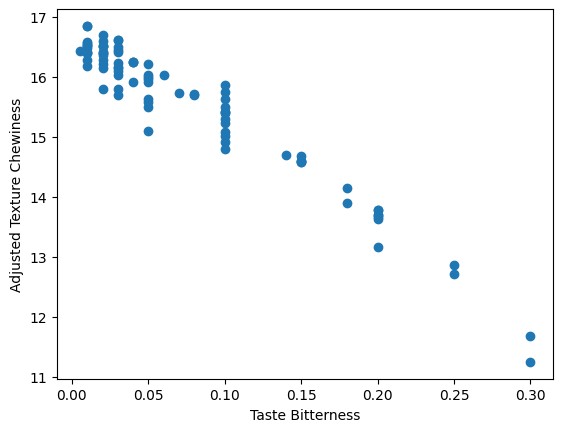

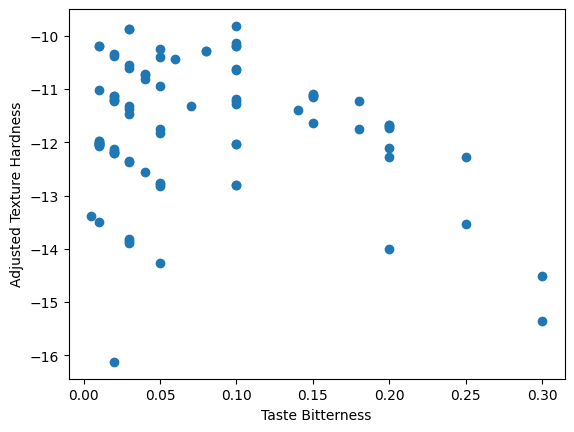

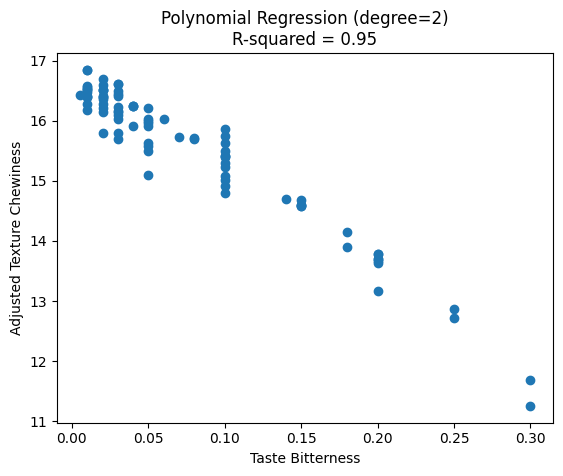

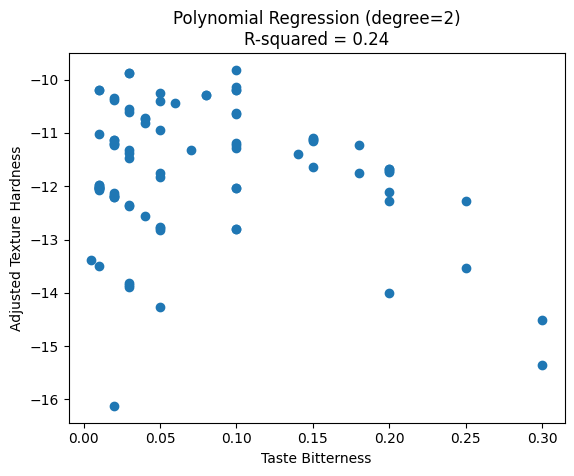

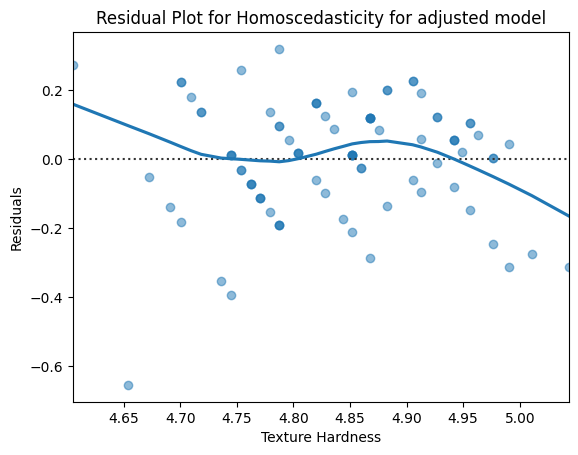

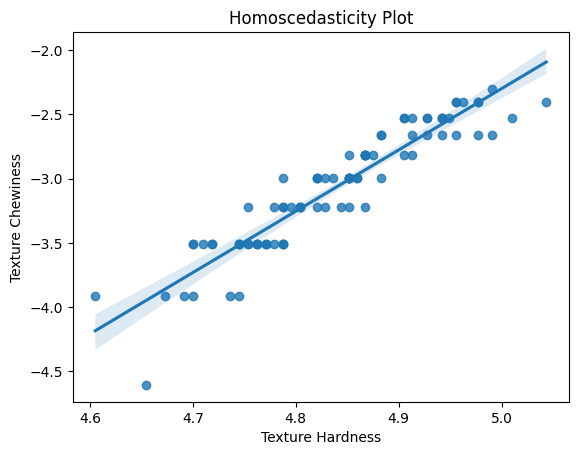

In [36]:
import statsmodels.api as sm

# define the model
X = data[['Texture Hardness', 'Taste Sweetness']]
X = sm.add_constant(X) # add constant term
y = data['Texture Chewiness']
mlr_model = sm.OLS(y, X).fit()

print(mlr_model.summary())

adjusted_chewiness = mlr_model.predict(data[['Taste Bitterness', 'Texture Hardness', 'Taste Sweetness']])

adjusted_hardness = mlr_model.predict(data[['Taste Bitterness', 'Texture Chewiness', 'Taste Sweetness']])

import matplotlib.pyplot as plt

plt.scatter(data['Taste Bitterness'], adjusted_chewiness)
plt.xlabel('Taste Bitterness')
plt.ylabel('Adjusted Texture Chewiness')
plt.show()

plt.scatter(data['Taste Bitterness'], adjusted_hardness)
plt.xlabel('Taste Bitterness')
plt.ylabel('Adjusted Texture Hardness')
plt.show()


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(data[['Taste Bitterness']])
y_chewiness = adjusted_chewiness.values.reshape(-1, 1)
y_hardness = adjusted_hardness.values.reshape(-1, 1)

# Fit polynomial regression models
poly_model_chewiness = LinearRegression().fit(X_poly, y_chewiness)
poly_model_hardness = LinearRegression().fit(X_poly, y_hardness)

# Predict adjusted Texture Chewiness and Texture Hardness using the polynomial models
adjusted_chewiness_pred = poly_model_chewiness.predict(X_poly)
adjusted_hardness_pred = poly_model_hardness.predict(X_poly)

# Calculate R-squared scores to evaluate model accuracy
r2_chewiness = r2_score(y_chewiness, adjusted_chewiness_pred)
r2_hardness = r2_score(y_hardness, adjusted_hardness_pred)

# Plot the polynomial regression models and the scatter plots
plt.scatter(data['Taste Bitterness'], adjusted_chewiness)
plt.xlabel('Taste Bitterness')
plt.ylabel('Adjusted Texture Chewiness')
plt.title(f'Polynomial Regression (degree=2)\nR-squared = {r2_chewiness:.2f}')
plt.show()

plt.scatter(data['Taste Bitterness'], adjusted_hardness)
plt.xlabel('Taste Bitterness')
plt.ylabel('Adjusted Texture Hardness')
plt.title(f'Polynomial Regression (degree=2)\nR-squared = {r2_hardness:.2f}')
plt.show()

sns.residplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data, lowess=True, scatter_kws={'alpha': 0.5})
plt.xlabel('Texture Hardness')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity for adjusted model')
plt.show()

sns.regplot(x='Texture Hardness', y='Texture Chewiness', data=cookie_data)
plt.xlabel('Texture Hardness')
plt.ylabel('Texture Chewiness')
plt.title('Homoscedasticity Plot')
plt.show()



## Bonus (20pts)

Lasso Regression is a modification of Regression that adds a regularization penalty to the the parameter $\mathbf{\beta}$ learned by the model. The loss function for Lasso is the following:

$$\mathcal{L}(\mathbf{\beta}) = \Vert \mathbf{y} - X\mathbf{\beta} \Vert^2 + \lambda \Vert \mathbf{\beta} \Vert = \beta^T X^T X \beta - 2\mathbf{\beta}^TX^T\mathbf{y}  + \mathbf{y}^T\mathbf{y} + \lambda \Vert \mathbf{\beta} \Vert$$

Where $\lambda$ is a tuning parameter specified by the user.

Using worksheet 17 as a guide:

1. create an animation like in part c) for Lasso Regression. [15pts]
2. create at least two more animations using different values for $\lambda$ and the true $\mathbf{\beta}$ you used to generate the dataset (try steeper / less steep curves, and higher or close to zero intercepts). Briefly explain some key takeaways on how to tune $\lambda$. [5pts]

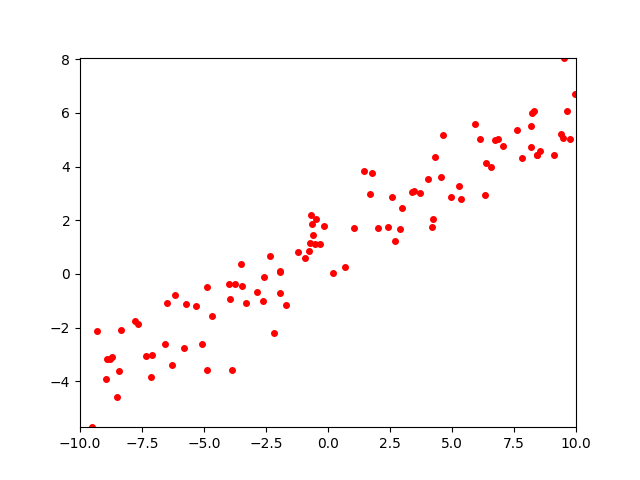

In [21]:
%matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im

TEMPFILE = "temp.png"
BATCH_SIZE = 80
beta = np.array([ 1 , .5 ])
xlin = -10.0 + 20.0 * np.random.random(100)
X = np.column_stack([np.ones((len(xlin), 1)), xlin])
y = beta[0]+(beta[1]*xlin)+np.random.randn(100)

fig, ax = plt.subplots()
ax.plot(xlin, y,'ro',markersize=4)
ax.set_xlim(-10, 10)
ax.set_ylim(min(y), max(y))
plt.show()

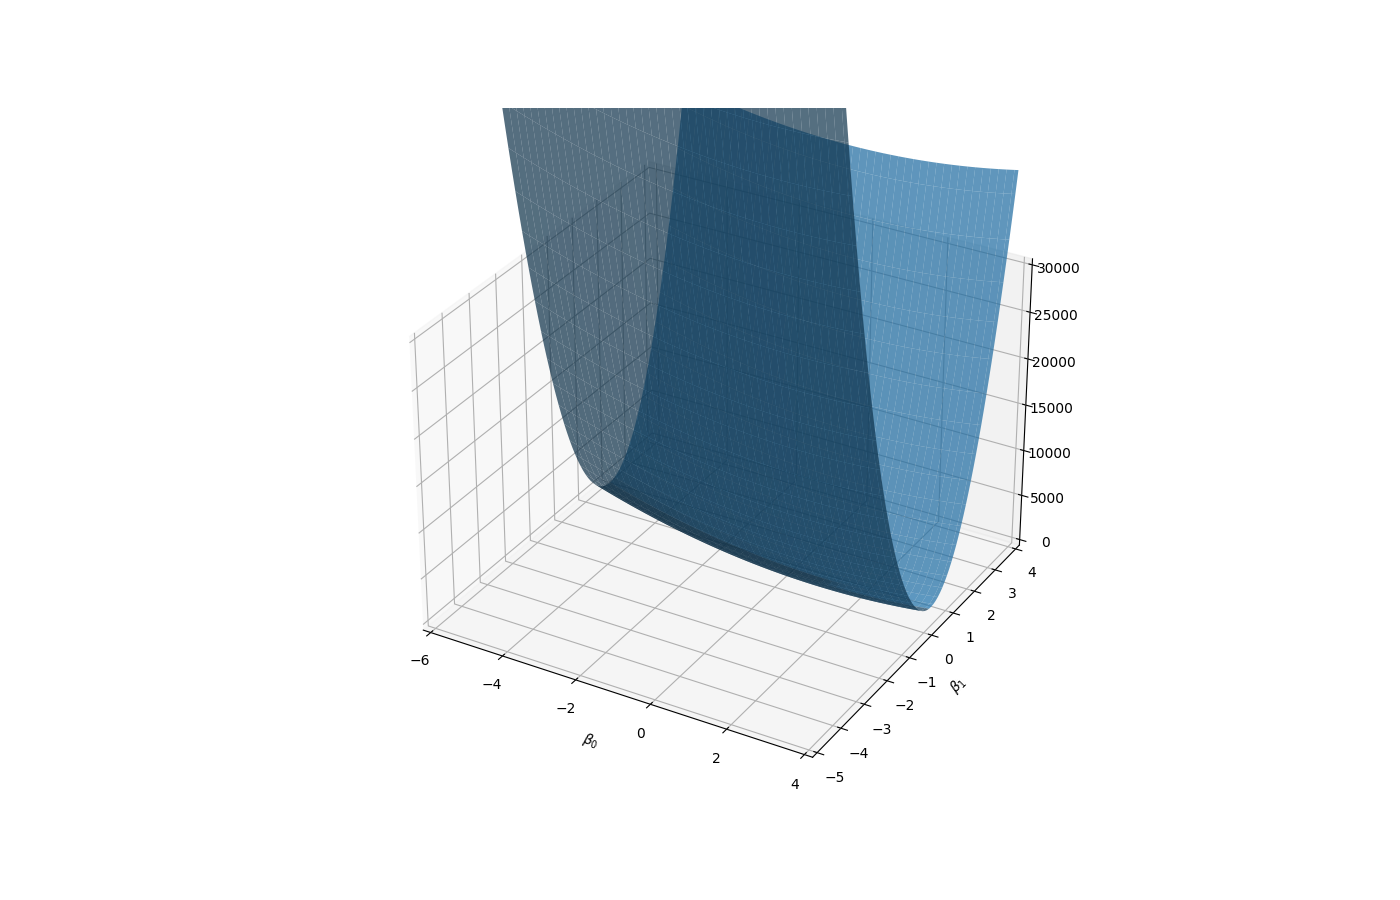

In [22]:
b0 = np.arange(-5, 4, 0.1)
b1 = np.arange(-5, 4, 0.1)
b0, b1 = np.meshgrid(b0, b1)
lam=0.01
beta_start = np.array([-5, -2])
learning_rate = 0.0002

def loss(X, y, beta,lam):
    return np.linalg.norm(y-X@beta)**2 + np.linalg.norm(beta)*lam

def get_cost(B0, B1,lam):
    res = []
    for b0, b1 in zip(B0, B1):
        line = []
        for i in range(len(b0)):
            beta = np.array([b0[i], b1[i]])
            line.append(loss(X, y, beta,lam))
        res.append(line)
    return np.array(res)

cost = get_cost(b0, b1,lam)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlim(-6, 4)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_ylim(-5, 4)
ax.set_zlim(0, 30000)

# Creating plot
ax.plot_surface(b0, b1, cost, alpha=.7)
 
# show plot
plt.show()

In [60]:
def snap_model(beta):
    xplot = np.linspace(-10,10,50)
    yestplot = beta[0] + beta[1]*xplot
    fig, ax = plt.subplots()
    ax.plot(xplot, yestplot,'b-',lw=2)
    ax.plot(xlin, y,'ro',markersize=4)
    ax.set_xlim(-10, 10)
    ax.set_ylim(min(y), max(y))
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def gradient(X, y, beta):
    return 2 * X.T @X @beta - 2 * X.T @y

def gradient_descent(X, y, beta_hat, learning_rate, epochs, images,lam):
    losses = [loss(X, y, beta_hat,lam)]
    betas = [beta_hat]

    for _ in range(epochs):
        images.append(snap_model(beta_hat))
        beta_hat = beta_hat - learning_rate * gradient(X, y, beta_hat)

        losses.append(loss(X, y, beta_hat,lam))
        betas.append(beta_hat)
        
    return np.array(betas), np.array(losses)

images = []
betas, losses = gradient_descent(X, y, beta_start, learning_rate, 100, images,lam)

images[0].save(
    'model-0.0002,0.01.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=200
)

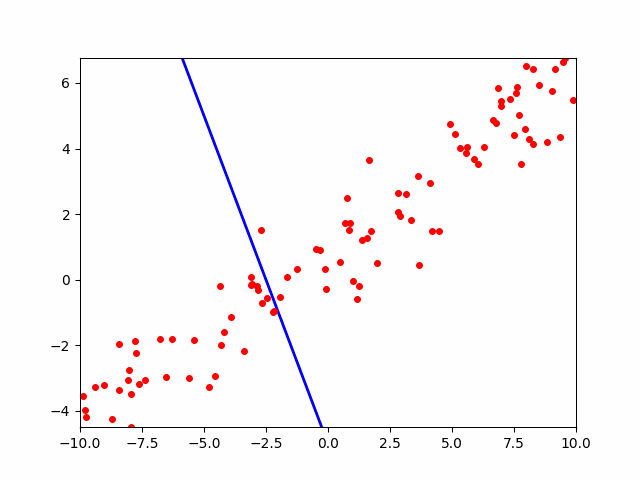

In [45]:
from IPython.display import Image
Image(filename="model-0.005,0,05.gif", width=500, height=500)

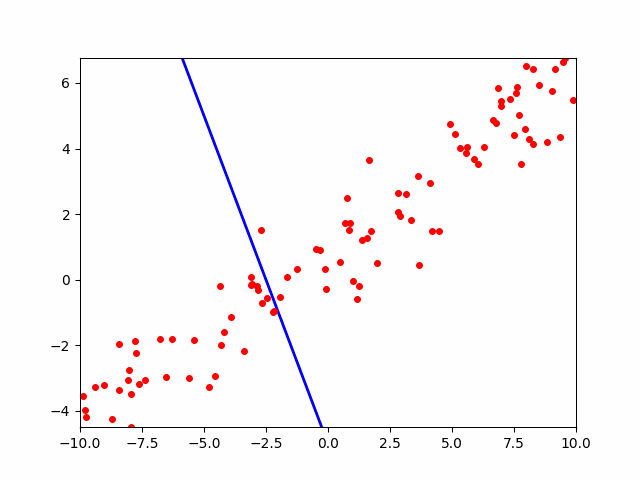

In [61]:
from IPython.display import Image
Image(filename='model-0.0002,0.01.gif', width=500, height=500)